In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from ucimlrepo import fetch_ucirepo
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import AdamW, Yogi  # You need TensorFlow Addons for AdamW and Yogi
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import time
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer

In [3]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the data
def load_data(file_path):
    data = pd.read_csv(file_path, sep=',', header=0)
    print(data.head())  # Inspect the first few rows
    data.columns = ['Index', 'PatientID', 'Date', 'Time', 'Code', 'Value']
    data = data.drop(['Index', 'PatientID'], axis=1)
    return data

# Convert Date and Time to datetime
def process_datetime(data):
    data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], errors='coerce')
    data = data.dropna(subset=['Datetime'])  # Drop rows with invalid dates
    data = data.drop(['Date', 'Time'], axis=1)
    return data

# Sort by datetime
def sort_by_datetime(data):
    data = data.sort_values(by='Datetime')
    data = data.reset_index(drop=True)
    return data

# One-hot encode the Code column
def one_hot_encode(data):
    data = pd.get_dummies(data, columns=['Code'])
    return data

# Ensure the Value column is numeric and handle errors
def ensure_numeric(data):
    data['Value'] = pd.to_numeric(data['Value'], errors='coerce')
    data = data.dropna(subset=['Value'])
    return data

# Categorize the Value column
def categorize_values(data):
    bins = [0, 70, 140, np.inf]
    labels = ['Low', 'Normal', 'High']
    data['Category'] = pd.cut(data['Value'], bins=bins, labels=labels, right=False)
    return data

# Encode the categories as one-hot vectors
def encode_categories(data):
    lb = LabelBinarizer()
    categories = lb.fit_transform(data['Category'])
    # Ensure the categories are one-hot encoded (lb.fit_transform can output binary arrays)
    if categories.shape[1] == 1:
        categories = np.hstack((1 - categories, categories))
    data['Category'] = list(categories)
    return data, lb

# Normalize the features (excluding target)
def normalize_features(data):
    scaler = MinMaxScaler()
    feature_cols = data.columns.difference(['Value', 'Category', 'Datetime'])
    data[feature_cols] = scaler.fit_transform(data[feature_cols])
    return data, scaler

# Split the data into training, validation, and test sets
def split_data(data, train_size=0.7, val_size=0.15):
    train_data, test_data = train_test_split(data, train_size=train_size, shuffle=False)
    val_data, test_data = train_test_split(test_data, test_size=val_size/(1-train_size), shuffle=False)
    return train_data, val_data, test_data

# Create TimeseriesGenerator for LSTM
def create_generators(train_data, val_data, test_data, window_length=10, batch_size=32):
    feature_cols = train_data.columns.difference(['Value', 'Category', 'Datetime'])
    
    train_gen = TimeseriesGenerator(train_data[feature_cols].values,
                                    np.vstack(train_data['Category'].values),
                                    length=window_length, batch_size=batch_size)
    
    val_gen = TimeseriesGenerator(val_data[feature_cols].values,
                                  np.vstack(val_data['Category'].values),
                                  length=window_length, batch_size=batch_size)
    
    test_gen = TimeseriesGenerator(test_data[feature_cols].values,
                                   np.vstack(test_data['Category'].values),
                                   length=window_length, batch_size=batch_size)
    
    return train_gen, val_gen, test_gen

In [128]:
# Define the NeuralNetworkModel class
class NeuralNetworkModel:
    def __init__(self):
        self.model = None

    def build_lstm(self, input_shape, num_classes, optimizer):
        self.model = Sequential()
        self.model.add(LSTM(units=16, input_shape=input_shape))
        self.model.add(Dense(num_classes, activation='softmax'))  # Assuming 3 classes for classification
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    def train(self, train_generator, val_generator, epochs, batch_size):
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        history = self.model.fit(train_generator, epochs=epochs, batch_size=batch_size, validation_data=val_generator, callbacks=[early_stopping, reduce_lr])
        return history

    def evaluate(self, test_generator):
        # Generate predictions
        y_pred_prob = self.model.predict(test_generator)

        # Extract true labels from test generator
        y_true = []
        for i in range(len(test_generator)):
            _, labels = test_generator[i]
            y_true.extend(labels)
        y_true = np.argmax(y_true, axis=1)

        # Convert predictions to class labels
        y_pred = np.argmax(y_pred_prob, axis=1)

        # Compute evaluation metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        return accuracy, precision, recall, f1

In [4]:
# Example usage
file_path = 'diabetes_data_all_patient.csv'  # Replace with the actual file path
# results = main(file_path)

In [5]:
# Main function to execute the steps and train the model

data = load_data(file_path)
data = process_datetime(data)
data = sort_by_datetime(data)
data = one_hot_encode(data)
data = ensure_numeric(data)
data = categorize_values(data)
data, lb = encode_categories(data)
data, scaler = normalize_features(data)

train_data, val_data, test_data = split_data(data)

train_gen, val_gen, test_gen = create_generators(train_data, val_data, test_data)


   Unnamed: 0  patient_id        date   time  code value
0           0           1  04-21-1991   9:09    58   100
1           1           1  04-21-1991   9:09    33     9
2           2           1  04-21-1991   9:09    34    13
3           3           1  04-21-1991  17:08    62   119
4           4           1  04-21-1991  17:08    33     7


In [6]:
# Train and evaluate the model
window_length = 10
batch_size = 32
num_classes = len(lb.classes_)
input_shape = (window_length, train_data.shape[1] - 1)

In [8]:
num_classes

3

In [7]:
 (window_length, train_data.shape[1] - 1)

(10, 26)

In [133]:
# List of optimizers to test for NN
optimizers = {
    'SGD': SGD(),
    'SGD_momentum': SGD(momentum=0.9),
    'Nesterov': SGD(momentum=0.9, nesterov=True),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'Adadelta': tf.keras.optimizers.Adadelta(),
    'Adam': Adam(),
    'AMSGrad': Adam(amsgrad=True),
    'AdamW': AdamW(weight_decay=1e-4),
    'Yogi': Yogi(),
    'Nadam': tf.keras.optimizers.Nadam(),
    'Adamax': tf.keras.optimizers.Adamax()
}

results = {}

# neural_network_model = NeuralNetworkModel()

for name, optimizer in optimizers.items():
    print(f"Training model with {name} optimizer...")
    neural_network_model = NeuralNetworkModel()
    neural_network_model.build_lstm(input_shape, num_classes, optimizer=optimizer)
    start_time = time.time()
    # history = neural_network_model.train(train_generator, y_train, val_generator, y_val, epochs=1, batch_size=32)
    history = neural_network_model.train(train_gen, val_gen, epochs= 50, batch_size=batch_size)
    end_time = time.time()
    test_accuracy, precision, recall, f1 = neural_network_model.evaluate(test_gen)
    training_time = end_time - start_time
    convergence_speed = len(history.history['loss'])
    results[name] = {
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'convergence_speed': convergence_speed,
        'training_time': training_time,
        'history': history
    }

Training model with SGD optimizer...
Epoch 1/50
640/640 [==============================] - 8s 10ms/step - loss: 0.9967 - accuracy: 0.5418 - val_loss: 0.9048 - val_accuracy: 0.6395 - lr: 0.0100
Epoch 2/50
640/640 [==============================] - 6s 10ms/step - loss: 0.9701 - accuracy: 0.5685 - val_loss: 0.8988 - val_accuracy: 0.6395 - lr: 0.0100
Epoch 3/50
640/640 [==============================] - 5s 7ms/step - loss: 0.9671 - accuracy: 0.5685 - val_loss: 0.8997 - val_accuracy: 0.6395 - lr: 0.0100
Epoch 4/50
640/640 [==============================] - 6s 9ms/step - loss: 0.9642 - accuracy: 0.5685 - val_loss: 0.8965 - val_accuracy: 0.6395 - lr: 0.0100
Epoch 5/50
640/640 [==============================] - 5s 8ms/step - loss: 0.9615 - accuracy: 0.5685 - val_loss: 0.8931 - val_accuracy: 0.6395 - lr: 0.0100
Epoch 6/50
640/640 [==============================] - 5s 9ms/step - loss: 0.9590 - accuracy: 0.5685 - val_loss: 0.8919 - val_accuracy: 0.6395 - lr: 0.0100
Epoch 7/50
640/640 [===========

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
640/640 [==============================] - 10s 12ms/step - loss: 0.9618 - accuracy: 0.5684 - val_loss: 0.8780 - val_accuracy: 0.6395 - lr: 0.0100
Epoch 2/50
640/640 [==============================] - 7s 10ms/step - loss: 0.9466 - accuracy: 0.5713 - val_loss: 0.8724 - val_accuracy: 0.6399 - lr: 0.0100
Epoch 3/50
640/640 [==============================] - 6s 10ms/step - loss: 0.9432 - accuracy: 0.5741 - val_loss: 0.9109 - val_accuracy: 0.6187 - lr: 0.0100
Epoch 4/50
640/640 [==============================] - 7s 10ms/step - loss: 0.9405 - accuracy: 0.5763 - val_loss: 0.8834 - val_accuracy: 0.6436 - lr: 0.0100
Epoch 5/50
640/640 [==============================] - 7s 11ms/step - loss: 0.9382 - accuracy: 0.5781 - val_loss: 0.9114 - val_accuracy: 0.6043 - lr: 0.0100
Epoch 6/50
640/640 [==============================] - 6s 10ms/step - loss: 0.9348 - accuracy: 0.5782 - val_loss: 0.8635 - val_accuracy: 0.6516 - lr: 0.0100
Epoch 7/50
640/640 [==============================] - 5s 8ms/st

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
640/640 [==============================] - 9s 12ms/step - loss: 0.9674 - accuracy: 0.5665 - val_loss: 0.8808 - val_accuracy: 0.6395 - lr: 0.0100
Epoch 2/50
640/640 [==============================] - 7s 10ms/step - loss: 0.9483 - accuracy: 0.5692 - val_loss: 0.8729 - val_accuracy: 0.6434 - lr: 0.0100
Epoch 3/50
640/640 [==============================] - 6s 10ms/step - loss: 0.9419 - accuracy: 0.5737 - val_loss: 0.8758 - val_accuracy: 0.6470 - lr: 0.0100
Epoch 4/50
640/640 [==============================] - 6s 10ms/step - loss: 0.9377 - accuracy: 0.5782 - val_loss: 0.8849 - val_accuracy: 0.6443 - lr: 0.0100
Epoch 5/50
640/640 [==============================] - 7s 11ms/step - loss: 0.9334 - accuracy: 0.5803 - val_loss: 0.8700 - val_accuracy: 0.6493 - lr: 0.0100
Epoch 6/50
640/640 [==============================] - 6s 10ms/step - loss: 0.9245 - accuracy: 0.5847 - val_loss: 0.8620 - val_accuracy: 0.6511 - lr: 0.0100
Epoch 7/50
640/640 [==============================] - 6s 10ms/st

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
640/640 [==============================] - 8s 10ms/step - loss: 0.9594 - accuracy: 0.5647 - val_loss: 0.8807 - val_accuracy: 0.6408 - lr: 0.0010
Epoch 2/50
640/640 [==============================] - 5s 9ms/step - loss: 0.9355 - accuracy: 0.5743 - val_loss: 0.8995 - val_accuracy: 0.6214 - lr: 0.0010
Epoch 3/50
640/640 [==============================] - 5s 8ms/step - loss: 0.9290 - accuracy: 0.5777 - val_loss: 0.8805 - val_accuracy: 0.6342 - lr: 0.0010
Epoch 4/50
640/640 [==============================] - 6s 9ms/step - loss: 0.9217 - accuracy: 0.5822 - val_loss: 0.8645 - val_accuracy: 0.6440 - lr: 0.0010
Epoch 5/50
640/640 [==============================] - 6s 9ms/step - loss: 0.9138 - accuracy: 0.5837 - val_loss: 0.8634 - val_accuracy: 0.6452 - lr: 0.0010
Epoch 6/50
640/640 [==============================] - 5s 8ms/step - loss: 0.9083 - accuracy: 0.5910 - val_loss: 0.8635 - val_accuracy: 0.6415 - lr: 0.0010
Epoch 7/50
640/640 [==============================] - 6s 9ms/step - l

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
640/640 [==============================] - 11s 9ms/step - loss: 1.0420 - accuracy: 0.5495 - val_loss: 0.9845 - val_accuracy: 0.6395 - lr: 0.0010
Epoch 2/50
640/640 [==============================] - 5s 7ms/step - loss: 1.0001 - accuracy: 0.5685 - val_loss: 0.9480 - val_accuracy: 0.6395 - lr: 0.0010
Epoch 3/50
640/640 [==============================] - 5s 7ms/step - loss: 0.9841 - accuracy: 0.5685 - val_loss: 0.9292 - val_accuracy: 0.6395 - lr: 0.0010
Epoch 4/50
640/640 [==============================] - 5s 7ms/step - loss: 0.9766 - accuracy: 0.5685 - val_loss: 0.9185 - val_accuracy: 0.6395 - lr: 0.0010
Epoch 5/50
640/640 [==============================] - 5s 7ms/step - loss: 0.9728 - accuracy: 0.5685 - val_loss: 0.9123 - val_accuracy: 0.6395 - lr: 0.0010
Epoch 6/50
640/640 [==============================] - 6s 9ms/step - loss: 0.9707 - accuracy: 0.5685 - val_loss: 0.9084 - val_accuracy: 0.6395 - lr: 0.0010
Epoch 7/50
640/640 [==============================] - 6s 9ms/step - l

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
640/640 [==============================] - 7s 8ms/step - loss: 1.1018 - accuracy: 0.2609 - val_loss: 1.0991 - val_accuracy: 0.2705 - lr: 0.0010
Epoch 2/50
640/640 [==============================] - 5s 8ms/step - loss: 1.0985 - accuracy: 0.2994 - val_loss: 1.0948 - val_accuracy: 0.3356 - lr: 0.0010
Epoch 3/50
640/640 [==============================] - 5s 8ms/step - loss: 1.0950 - accuracy: 0.3438 - val_loss: 1.0903 - val_accuracy: 0.4003 - lr: 0.0010
Epoch 4/50
640/640 [==============================] - 5s 7ms/step - loss: 1.0916 - accuracy: 0.3955 - val_loss: 1.0858 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 5/50
640/640 [==============================] - 4s 7ms/step - loss: 1.0881 - accuracy: 0.4422 - val_loss: 1.0813 - val_accuracy: 0.4974 - lr: 0.0010
Epoch 6/50
640/640 [==============================] - 5s 7ms/step - loss: 1.0846 - accuracy: 0.4739 - val_loss: 1.0769 - val_accuracy: 0.5310 - lr: 0.0010
Epoch 7/50
640/640 [==============================] - 5s 8ms/step - lo

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
640/640 [==============================] - 9s 11ms/step - loss: 0.9509 - accuracy: 0.5708 - val_loss: 0.8810 - val_accuracy: 0.6507 - lr: 0.0010
Epoch 2/50
640/640 [==============================] - 6s 10ms/step - loss: 0.9193 - accuracy: 0.5818 - val_loss: 0.8676 - val_accuracy: 0.6511 - lr: 0.0010
Epoch 3/50
640/640 [==============================] - 6s 10ms/step - loss: 0.9112 - accuracy: 0.5895 - val_loss: 0.8750 - val_accuracy: 0.6322 - lr: 0.0010
Epoch 4/50
640/640 [==============================] - 6s 10ms/step - loss: 0.9065 - accuracy: 0.5950 - val_loss: 0.8772 - val_accuracy: 0.6370 - lr: 0.0010
Epoch 5/50
640/640 [==============================] - 6s 10ms/step - loss: 0.9029 - accuracy: 0.5953 - val_loss: 0.8737 - val_accuracy: 0.6418 - lr: 0.0010
Epoch 6/50
640/640 [==============================] - 7s 10ms/step - loss: 0.9004 - accuracy: 0.5985 - val_loss: 0.8606 - val_accuracy: 0.6436 - lr: 0.0010
Epoch 7/50
640/640 [==============================] - 7s 11ms/st

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
640/640 [==============================] - 7s 9ms/step - loss: 0.9621 - accuracy: 0.5658 - val_loss: 0.8759 - val_accuracy: 0.6493 - lr: 0.0010
Epoch 2/50
640/640 [==============================] - 5s 8ms/step - loss: 0.9272 - accuracy: 0.5784 - val_loss: 0.8663 - val_accuracy: 0.6461 - lr: 0.0010
Epoch 3/50
640/640 [==============================] - 6s 9ms/step - loss: 0.9129 - accuracy: 0.5894 - val_loss: 0.8741 - val_accuracy: 0.6365 - lr: 0.0010
Epoch 4/50
640/640 [==============================] - 5s 8ms/step - loss: 0.9044 - accuracy: 0.5940 - val_loss: 0.8640 - val_accuracy: 0.6424 - lr: 0.0010
Epoch 5/50
640/640 [==============================] - 5s 7ms/step - loss: 0.8994 - accuracy: 0.6006 - val_loss: 0.8644 - val_accuracy: 0.6466 - lr: 0.0010
Epoch 6/50
640/640 [==============================] - 5s 8ms/step - loss: 0.8954 - accuracy: 0.6028 - val_loss: 0.8595 - val_accuracy: 0.6440 - lr: 0.0010
Epoch 7/50
640/640 [==============================] - 5s 8ms/step - lo

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
640/640 [==============================] - 8s 10ms/step - loss: 0.9562 - accuracy: 0.5663 - val_loss: 0.8885 - val_accuracy: 0.6516 - lr: 0.0010
Epoch 2/50
640/640 [==============================] - 6s 10ms/step - loss: 0.9300 - accuracy: 0.5745 - val_loss: 0.8807 - val_accuracy: 0.6429 - lr: 0.0010
Epoch 3/50
640/640 [==============================] - 6s 10ms/step - loss: 0.9175 - accuracy: 0.5803 - val_loss: 0.8665 - val_accuracy: 0.6459 - lr: 0.0010
Epoch 4/50
640/640 [==============================] - 8s 12ms/step - loss: 0.9104 - accuracy: 0.5874 - val_loss: 0.8612 - val_accuracy: 0.6466 - lr: 0.0010
Epoch 5/50
640/640 [==============================] - 6s 9ms/step - loss: 0.9066 - accuracy: 0.5942 - val_loss: 0.8555 - val_accuracy: 0.6479 - lr: 0.0010
Epoch 6/50
640/640 [==============================] - 5s 8ms/step - loss: 0.9036 - accuracy: 0.5978 - val_loss: 0.8647 - val_accuracy: 0.6456 - lr: 0.0010
Epoch 7/50
640/640 [==============================] - 5s 8ms/step 

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
640/640 [==============================] - 12s 15ms/step - loss: 0.9498 - accuracy: 0.5707 - val_loss: 0.8897 - val_accuracy: 0.6381 - lr: 0.0100
Epoch 2/50
640/640 [==============================] - 10s 15ms/step - loss: 0.9201 - accuracy: 0.5837 - val_loss: 0.8683 - val_accuracy: 0.6420 - lr: 0.0100
Epoch 3/50
640/640 [==============================] - 9s 15ms/step - loss: 0.8953 - accuracy: 0.6046 - val_loss: 0.8625 - val_accuracy: 0.6310 - lr: 0.0100
Epoch 4/50
640/640 [==============================] - 9s 13ms/step - loss: 0.8824 - accuracy: 0.6083 - val_loss: 0.8536 - val_accuracy: 0.6422 - lr: 0.0100
Epoch 5/50
640/640 [==============================] - 9s 14ms/step - loss: 0.8702 - accuracy: 0.6140 - val_loss: 0.8606 - val_accuracy: 0.6356 - lr: 0.0100
Epoch 6/50
640/640 [==============================] - 9s 14ms/step - loss: 0.8635 - accuracy: 0.6136 - val_loss: 0.8530 - val_accuracy: 0.6377 - lr: 0.0100
Epoch 7/50
640/640 [==============================] - 9s 14ms/

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
640/640 [==============================] - 10s 13ms/step - loss: 0.9604 - accuracy: 0.5653 - val_loss: 0.8797 - val_accuracy: 0.6468 - lr: 0.0010
Epoch 2/50
640/640 [==============================] - 7s 12ms/step - loss: 0.9313 - accuracy: 0.5748 - val_loss: 0.8742 - val_accuracy: 0.6479 - lr: 0.0010
Epoch 3/50
640/640 [==============================] - 7s 11ms/step - loss: 0.9205 - accuracy: 0.5802 - val_loss: 0.8704 - val_accuracy: 0.6482 - lr: 0.0010
Epoch 4/50
640/640 [==============================] - 7s 11ms/step - loss: 0.9113 - accuracy: 0.5856 - val_loss: 0.8654 - val_accuracy: 0.6452 - lr: 0.0010
Epoch 5/50
640/640 [==============================] - 7s 11ms/step - loss: 0.9053 - accuracy: 0.5954 - val_loss: 0.8793 - val_accuracy: 0.6395 - lr: 0.0010
Epoch 6/50
640/640 [==============================] - 7s 11ms/step - loss: 0.9001 - accuracy: 0.6012 - val_loss: 0.8583 - val_accuracy: 0.6498 - lr: 0.0010
Epoch 7/50
640/640 [==============================] - 7s 11ms/s

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
640/640 [==============================] - 7s 9ms/step - loss: 0.9764 - accuracy: 0.5663 - val_loss: 0.8960 - val_accuracy: 0.6395 - lr: 0.0010
Epoch 2/50
640/640 [==============================] - 5s 8ms/step - loss: 0.9570 - accuracy: 0.5685 - val_loss: 0.8806 - val_accuracy: 0.6395 - lr: 0.0010
Epoch 3/50
640/640 [==============================] - 5s 7ms/step - loss: 0.9480 - accuracy: 0.5685 - val_loss: 0.8772 - val_accuracy: 0.6395 - lr: 0.0010
Epoch 4/50
640/640 [==============================] - 5s 7ms/step - loss: 0.9414 - accuracy: 0.5690 - val_loss: 0.8747 - val_accuracy: 0.6420 - lr: 0.0010
Epoch 5/50
640/640 [==============================] - 5s 7ms/step - loss: 0.9372 - accuracy: 0.5728 - val_loss: 0.8784 - val_accuracy: 0.6514 - lr: 0.0010
Epoch 6/50
640/640 [==============================] - 5s 8ms/step - loss: 0.9330 - accuracy: 0.5761 - val_loss: 0.8757 - val_accuracy: 0.6525 - lr: 0.0010
Epoch 7/50
640/640 [==============================] - 5s 7ms/step - lo

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [134]:
# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Precision - {result['precision']:.4f}, "
          f"Recall - {result['recall']:.4f}, "
          f"F1-score - {result['f1_score']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")


Results:
SGD: Test Accuracy - 0.6297, Precision - 0.5083, Recall - 0.6297, F1-score - 0.5326, Convergence Speed - 46 epochs, Training Time - 248.12 seconds
SGD_momentum: Test Accuracy - 0.6137, Precision - 0.5277, Recall - 0.6137, F1-score - 0.5674, Convergence Speed - 50 epochs, Training Time - 268.41 seconds
Nesterov: Test Accuracy - 0.6223, Precision - 0.5242, Recall - 0.6223, F1-score - 0.5677, Convergence Speed - 46 epochs, Training Time - 254.14 seconds
RMSprop: Test Accuracy - 0.6233, Precision - 0.5258, Recall - 0.6233, F1-score - 0.5692, Convergence Speed - 46 epochs, Training Time - 258.73 seconds
Adagrad: Test Accuracy - 0.6246, Precision - 0.3902, Recall - 0.6246, F1-score - 0.4803, Convergence Speed - 50 epochs, Training Time - 251.01 seconds
Adadelta: Test Accuracy - 0.6246, Precision - 0.3902, Recall - 0.6246, F1-score - 0.4803, Convergence Speed - 50 epochs, Training Time - 259.83 seconds
Adam: Test Accuracy - 0.6260, Precision - 0.5301, Recall - 0.6260, F1-score - 0.5

In [135]:
# Data extraction for the summary
data_info = {
    'Data Name': ["Diabetic-Prediction"] * len(optimizers),
    'Data Size': [train_data.shape[0]] * len(optimizers),
    'Number of Features': [train_data.shape[1] - 1] * len(optimizers),
    'Target Feature Type': ["Categorical"] * len(optimizers),
    'Neural Network Architecture': ["LSTM"] * len(optimizers),
    'Optimization Method': list(optimizers.keys())
}

# Extract results for each optimization method
results_info = {
    'Optimization Method': [],
    'Test Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'Convergence Speed': [],
    'Training Time': [],
    'Training Loss': [],
    'Validation Loss': []
}

# Add the evaluation results for each optimizer
for optimizer, result in results.items():
    results_info['Optimization Method'].append(optimizer)
    results_info['Test Accuracy'].append(result['test_accuracy'])
    results_info['Precision'].append(result['precision'])
    results_info['Recall'].append(result['recall'])
    results_info['F1-score'].append(result['f1_score'])
    results_info['Convergence Speed'].append(result['convergence_speed'])
    results_info['Training Time'].append(result['training_time'])
    results_info['Training Loss'].append(result['history'].history['loss'][0])
    results_info['Validation Loss'].append(result['history'].history['val_loss'][0])

# Create DataFrames and merge them for final results
data_df = pd.DataFrame(data_info)
results_df = pd.DataFrame(results_info)
final_df = pd.merge(data_df, results_df, on='Optimization Method')

# Show the final merged data
final_df.head(12)

,Data Name,Data Size,Number of Features,Target Feature Type,Neural Network Architecture,Optimization Method,Test Accuracy,Precision,Recall,F1-score,Convergence Speed,Training Time,Training Loss,Validation Loss
0,Diabetic-Prediction,20470,26,Categorical,LSTM,SGD,0.629655,0.508330,0.629655,0.532616,46,248.115949,0.996659,0.904799
1,Diabetic-Prediction,20470,26,Categorical,LSTM,SGD_momentum,0.613662,0.527721,0.613662,0.567420,50,268.410836,0.961809,0.878020
2,Diabetic-Prediction,20470,26,Categorical,LSTM,Nesterov,0.622344,0.524222,0.622344,0.567742,46,254.137279,0.967440,0.880779
3,Diabetic-Prediction,20470,26,Categorical,LSTM,RMSprop,0.623258,0.525845,0.623258,0.569201,46,258.734832,0.959436,0.880651
4,Diabetic-Prediction,20470,26,Categorical,LSTM,Adagrad,0.624629,0.390161,0.624629,0.480308,50,251.006436,1.041951,0.984506
5,Diabetic-Prediction,20470,26,Categorical,LSTM,Adadelta,0.624629,0.390161,0.624629,0.480308,50,259.828446,1.101794,1.099127
6,Diabetic-Prediction,20470,26,Categorical,LSTM,Adam,0.626000,0.530108,0.626000,0.573199,40,221.221264,0.950881,0.880986
7,Diabetic-Prediction,20470,26,Categorical,LSTM,AMSGrad,0.630112,0.522877,0.630112,0.566950,29,173.718802,0.962067,0.875906
8,Diabetic-Prediction,20470,26,Categorical,LSTM,AdamW,0.628970,0.515500,0.628970,0.556450,33,183.488936,0.956228,0.888528
9,Diabetic-Prediction,20470,26,Categorical,LSTM,Yogi,0.626913,0.528072,0.626913,0.571767,29,238.887857,0.949752,0.889695


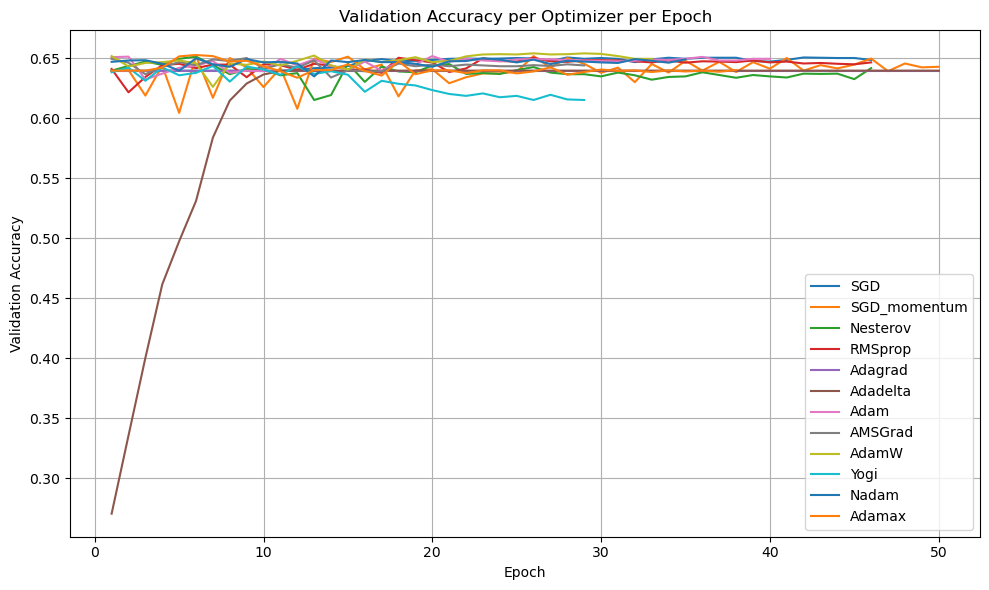

In [136]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Test Accuracy per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the validation accuracy history for this optimizer
    if 'val_accuracy' in result['history'].history:
        val_acc_history = result['history'].history['val_accuracy']
    else:
        # Sometimes the key might be 'val_acc', depending on TensorFlow version
        val_acc_history = result['history'].history.get('val_acc', [])

    # Plot the validation accuracy history
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label=optimizer_name)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy per Optimizer per Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


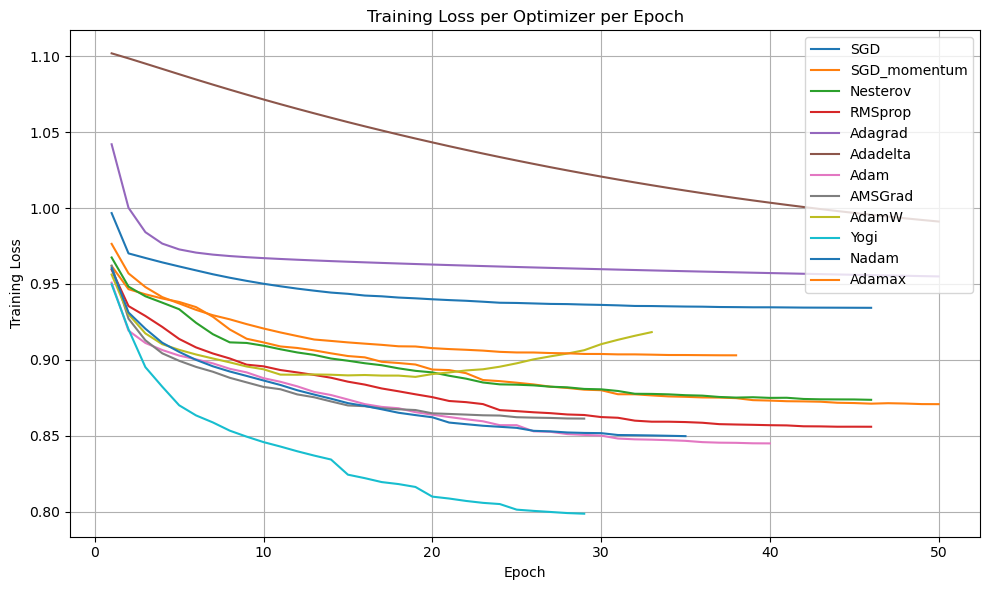

In [137]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Training Loss per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the training loss history for this optimizer
    if 'loss' in result['history'].history:
        loss_history = result['history'].history['loss']
    else:
        # In case the loss key isn't found (unexpected behavior), use a default empty list
        loss_history = []

    # Plot the training loss history
    plt.plot(range(1, len(loss_history) + 1), loss_history, label=optimizer_name)

# Set plot labels and titles
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Optimizer per Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [138]:
final_df.to_csv('Diabetic-Prediction', index=False)